In [1]:
import hyperspy.api as hs
import numpy as np
import scipy.ndimage as ndi
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
import matplotlib.patches as patches
import matplotlib
path = os.getcwd() + "/"
plt.set_cmap("cubehelix")
plt.close()

%matplotlib inline
matplotlib.rcParams.update(
    {'figure.figsize': (7,7)})

#dp = hs.load(path + "05 nbd 30 cm.dm3")
#dp = hs.load(path + "nbd 40cm aperture 3.dm3")
#dat=dp.data
#dat=dat.astype("double")

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                        + c*((y-yo)**2)))                                   
    return g.ravel()

In [2]:
imagelist=[]
for root,dirs,files in os.walk(path):
    for name in files:
        if name[-4:] == ".dm3":
            print(os.path.join(root,name))
            imagelist.append(os.path.join(root,name))
        if name[-5:] == ".tiff":
            print(os.path.join(root,name))
            imagelist.append(os.path.join(root,name))
        if name[-5:] == ".hdf5":
            print(os.path.join(root,name))
            imagelist.append(os.path.join(root,name))

/Users/MF/Google Drive/Python/ImageAnalysis/Diffraction/test_files/05 nbd 30 cm.dm3
/Users/MF/Google Drive/Python/ImageAnalysis/Diffraction/test_files/nbd 3.dm3
/Users/MF/Google Drive/Python/ImageAnalysis/Diffraction/test_files/nbd 40cm aperture 3.dm3
/Users/MF/Google Drive/Python/ImageAnalysis/Diffraction/test_files/nbd central spot ap 4 200cm with OA 4.hdf5


In [5]:
dp = hs.load(imagelist[0])
dp.data=dp.data.astype("double")

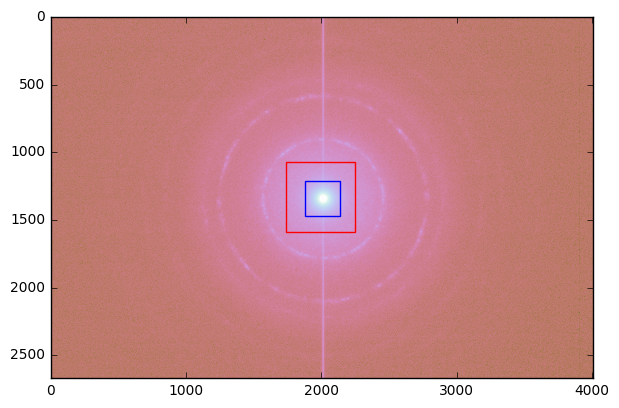

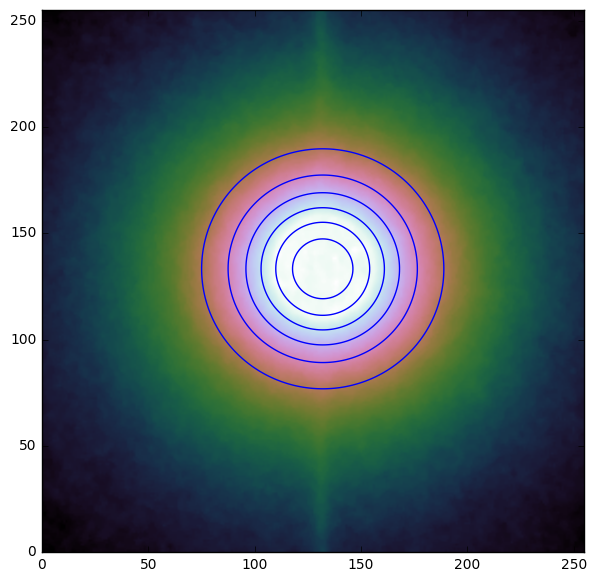

Amplitude (Counts): 16460.4831614
Center X (pix): 131.987196542
Center Y (pix): 133.322249159
Sigma X (pix): 27.0874355459
Sigma Y (pix): 27.3410203246
Theta (Deg): -628.975796835
Offset (Counts): 615.728906699


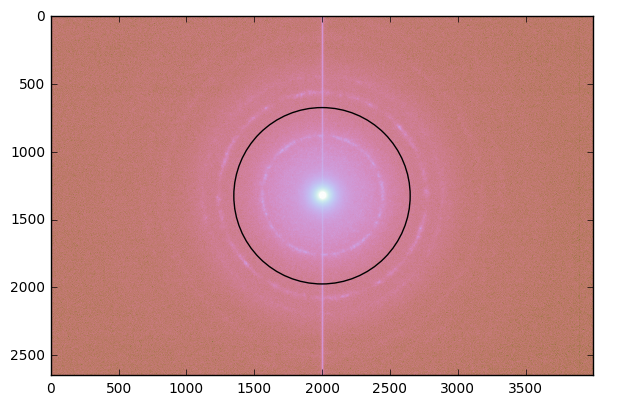

In [8]:
#user parameters

MedianKernelSize =3
MinimumPixelValue = 0.01

SearchBox1_Sizex = 512
SearchBox1_Sizey = 512

SearchBox2_Sizex = 256
SearchBox2_Sizey = 256

GaussianKernelSigma =10.0
FitContours = 6
FitColor = 'b'


#Start of Routine
med=ndi.filters.median_filter(dp.data,MedianKernelSize) #median filtered image
med=med-med.min()+ MinimumPixelValue #removing any negative pixels 


#image dimensions
sx=len(dp.data[0]) 
sy=len(dp.data)

cent1=np.array(ndi.measurements.center_of_mass(med)) #finding centroid of first cropped image

#defines search box for central spot
h=SearchBox1_Sizex
w=SearchBox1_Sizey

#crops out search box
xmin=int((cent1-[h/2,w/2])[1])
xmax=int((cent1+[h/2,w/2])[1])
ymin=int((cent1-[h/2,w/2])[0])
ymax=int((cent1+[h/2,w/2])[0])
area=med[ymin:ymax,xmin:xmax]


#finds centroid of cropped area
cent2=np.array(ndi.measurements.center_of_mass(area)) #finding centroid of first cropped image

#defines region for fit
w2=SearchBox2_Sizex
h2=SearchBox2_Sizey

#crops out image to preform fit on
xmin2=int((cent2-[w2/2,h2/2])[1])
xmax2=int((cent2+[w2/2,h2/2])[1])
ymin2=int((cent2-[w2/2,h2/2])[0])
ymax2=int((cent2+[w2/2,h2/2])[0])
fit_area=area[ymin2:ymax2,xmin2:xmax2]

#plt.imshow(np.log(fit_area))
#plt.show()
plt.close()
fig,ax = plt.subplots(1)
ax.imshow(np.log(med))
rect = patches.Rectangle([xmin,ymin],w,h,linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
rect2 = patches.Rectangle(np.array([xmin,ymin])+cent2-[h2/2,w2/2],w2,h2,linewidth=1,edgecolor='b',facecolor='none')
ax.add_patch(rect2)
plt.show()

#performs gaussian smoothing to "desaturate" peak
gaus = ndi.filters.gaussian_filter(fit_area,GaussianKernelSigma)

# Create x and y indices
x = np.arange(0, len(gaus[0]), 1)
y = np.arange(0, len(gaus), 1)
x,y = np.meshgrid(x, y)

#amplitude center_x, center_y, sigma_x, sigma_y, theta, offset 
#parameters are estimated as:
#Amplitude = Max Value
#center_x, center_y = middle pixel
#sigma_x, sigma_y = sigma for gaussian blur
#theta = 0
#offset = Min Value
p0 = [gaus.max(),len(x)/2,len(y)/2,GaussianKernelSigma,GaussianKernelSigma,0,gaus.min()]

#Non-Linear LSq fitting
coeff, var_matrix = curve_fit(twoD_Gaussian, (x, y), gaus.ravel(), p0=p0)
data_fitted = twoD_Gaussian((x, y), *coeff)

#plots fit results
fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.imshow(np.log(fit_area), origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(len(x),len(y)), FitContours, colors=FitColor)
plt.show()

print("Amplitude (Counts): "+ str(coeff[0]))
print("Center X (pix): "+ str(coeff[1]))
print("Center Y (pix): "+ str(coeff[2]))
print("Sigma X (pix): "+ str(coeff[3]))
print("Sigma Y (pix): "+ str(coeff[4]))
print("Theta (Deg): "+ str(180/np.pi*coeff[5]))
print("Offset (Counts): "+ str(coeff[6]))

centroid_total = np.array([xmin+xmin2,ymin+ymin2])+np.array([coeff[1],coeff[2]])

cx=centroid_total[0]
cy=centroid_total[1]
csx=min([cx,len(med[0])-cx])
csy=min([cy,len(med)-cy])
square_size=min([csx,csy])
center_crop_square = med[int(cy-square_size):int(cy+square_size),int(cx-square_size):int(cx+square_size)]
center_crop = med[int(cy-csy):int(cy+csy),int(cx-csx):int(cx+csx)]

radius =650
fig,ax = plt.subplots(1)
ax.imshow(np.log(center_crop))
circ = patches.Circle(np.array([len(center_crop[0])/2,len(center_crop)/2]),radius,linewidth=1,edgecolor='k',facecolor='none')
ax.add_patch(circ)
plt.show()


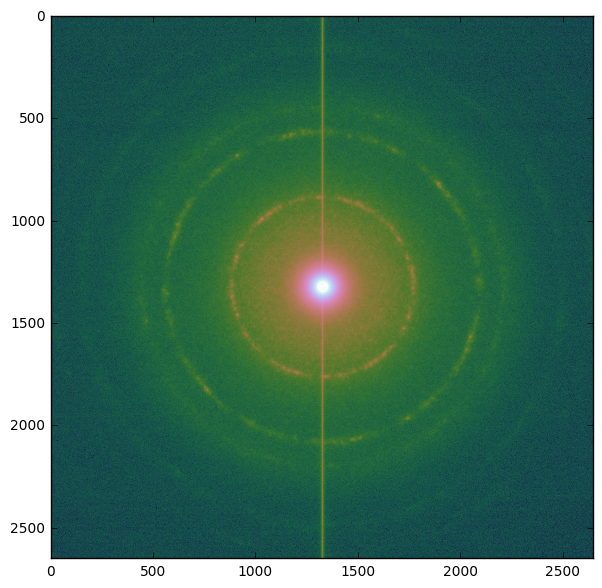

In [9]:
cx=centroid_total[0]
cy=centroid_total[1]
csx=min([cx,len(med[0])-cx])
csy=min([cy,len(med)-cy])
square_size=min([csx,csy])
center_crop = med[int(cy-square_size):int(cy+square_size),int(cx-square_size):int(cx+square_size)]
plt.imshow(np.log(center_crop))
plt.set_cmap("cubehelix")
plt.show()

In [14]:
#rotational averaging
lx=len(center_crop)
ly=len(center_crop)
imarg = np.array([(x, y) for x in range(0,lx) for y in range(0,ly)])
imarg = np.split(imarg,lx)
imcen = np.zeros((lx,ly,2))+0.5*np.array((lx,ly))
imcen2 = imarg - imcen
theta=(180/np.pi)*np.arctan2(imcen2[:,:,0],imcen2[:,:,1])
rho=np.sqrt(imcen2[:,:,1]**2+imcen2[:,:,0]**2)

rhodata = np.array([(rho[x,y],center_crop[x,y]) for x in range(0,lx-1) for y in range(0,ly-1)])
rhodata = np.transpose(rhodata)
#x=rhodata[0]
#y=rhodata[1]
#plt.plot(x,y,'ro')
#plt.show()

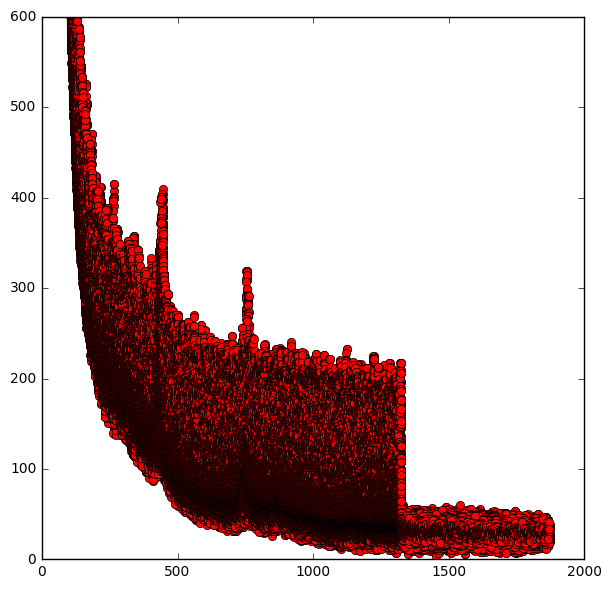

In [15]:
x=rhodata[0]
y=rhodata[1]
plt.plot(x,y,'ro')
plt.ylim(0,600)
plt.show()

In [16]:
radial_bin=2

rhodatat=rhodata.transpose()
radial_sort=rhodatat[np.lexsort((rhodatat[:,1],rhodatat[:,0]))]
j=1.0
radial_int=[]
meow=[]
for x in radial_sort:
    if x[0]<=square_size:
        if x[0]<=j:
            meow.append([x[0],x[1]])
        else:
            radial_int.append(np.array(meow).mean(0))
            meow=[]
            j+=radial_bin  

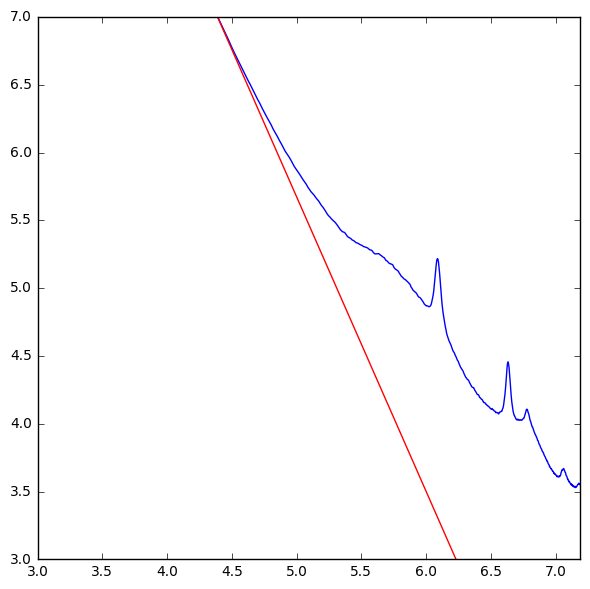

In [24]:
#powerlaw fit to background
bot=3.5
top=4.5



xx=np.array(radial_int).transpose()[0]
yy=np.array(radial_int).transpose()[1]

xl=np.log(xx)
yl=np.log(yy)
fit_range=np.where(np.logical_and(xl<=top,xl>=bot))

xlc=xl[fit_range[0]]
ylc=yl[fit_range[0]]

z=np.polyfit(xlc,ylc,1)
p=np.poly1d(z)


plt.plot(xl,yl)
plt.plot(xl,p(xl),'r')
plt.plot()
plt.plot
plt.xlim(3,np.log(square_size))
plt.ylim(3,7)
plt.show()

A= np.exp(z[1])
r= z[0]

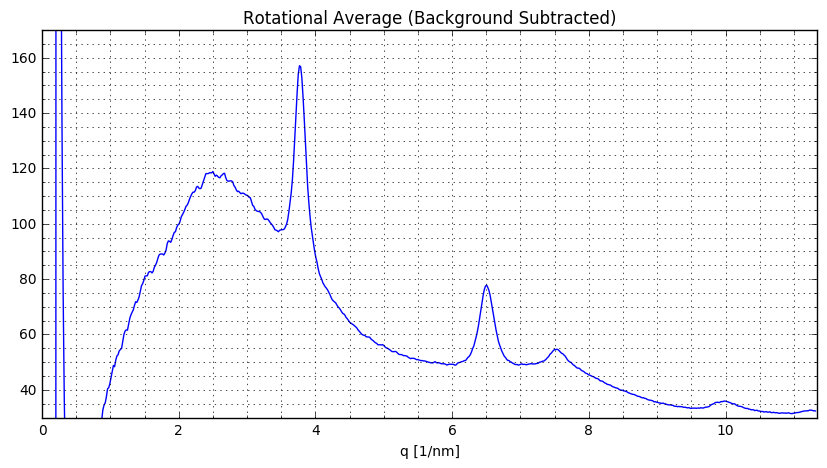

In [21]:
xcal=xx*dp.axes_manager[0].scale
plt.figure(figsize=(10,5))
plt.plot(xcal,yy-A*(xx)**(r))
plt.xlim(0,square_size*dp.axes_manager[0].scale)
plt.ylim(30,170)

plt.xlabel("q [" + dp.axes_manager[0].units + "]" )
plt.title("Rotational Average (Background Subtracted)")

plt.grid(True,which="both")
plt.minorticks_on()
plt.show()

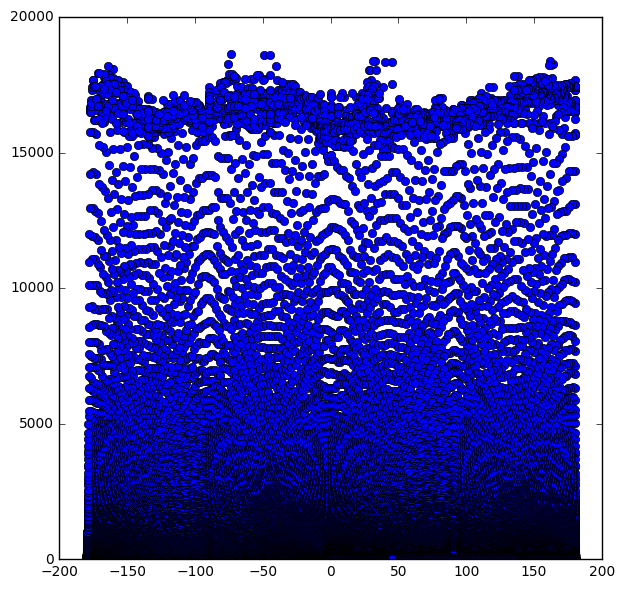

In [22]:
thetadata = np.array([(theta[x,y],center_crop[x,y]) for x in range(0,lx-1) for y in range(0,ly-1)])
thetadata = np.transpose(thetadata)
xx=thetadata[0]
yy=thetadata[1]
plt.plot(xx,yy,'bo')
plt.show()

In [69]:
theta_bin=2

thetadatat=thetadata.transpose()
theta_sort=thetadatat[np.lexsort((thetadatat[:,1],thetadatat[:,0]))]
r_theta=thetadatat[np.lexsort((rhodatat[:,1],rhodatat[:,0]))]

j=-179.0
theta_int=[]
meow=[]

for x in theta_sort:
    #if x[0]<=square_size:
        if x[0]<=j:
            meow.append([x[0],x[1]])
        else:
            theta_int.append(np.array(meow).mean(0))
            meow=[]
            j+=theta_bin  
xx=np.array(theta_int).transpose()[0]
yy=np.array(theta_int).transpose()[1]

In [70]:
theta_bin=2

r_theta_sort=[[radial_sort[x,0],r_theta[x,0],radial_sort[x,1]] for x in range(0,len(radial_sort))]
r_bot = 6.0
r_top = 7.0

j=-179.0
r_theta_int=[]
meow=[]

for x in r_theta_sort:
    #if x[0]<=square_size:
    if x[0]>=r_bot and x[0]<=r_top:
        if x[1]<=j:
            meow.append([x[1],x[2]])
        else:
        #    r_theta_int.append(np.array(meow).mean(0))
        #    meow=[]
        #    j+=theta_bin  
#xx=np.array(r_theta_int).transpose()[0]
#yy=np.array(r_theta_int).transpose()[1]

True
True
True
True
True
True
True
True
True
True
True
True


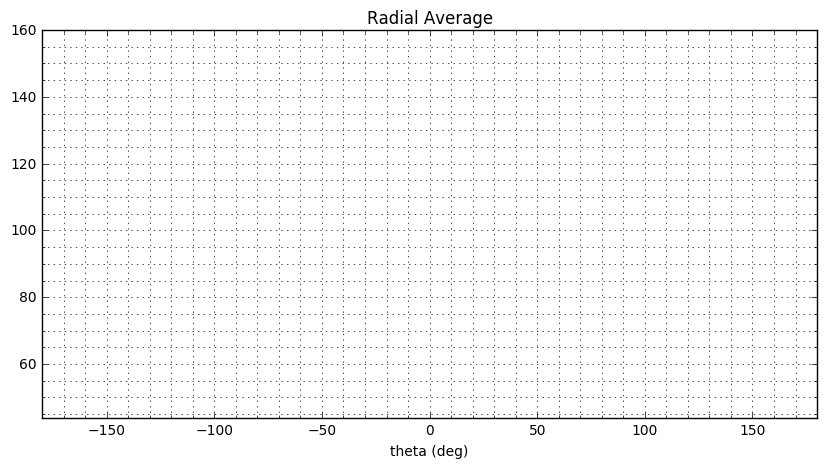

In [61]:
plt.figure(figsize=(10,5))
plt.plot(xx,yy)
plt.xlim(-180,180)
plt.ylim(44,160)

plt.xlabel("theta (deg)" )
plt.title("Radial Average")

plt.grid(True,which="both")
plt.minorticks_on()
#plt.grid(True,which="minor")
plt.show()